The data type:
 Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
The dataset has 918 samples and 12 features.

The head of data：
   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0  False   True              False  ...              False     

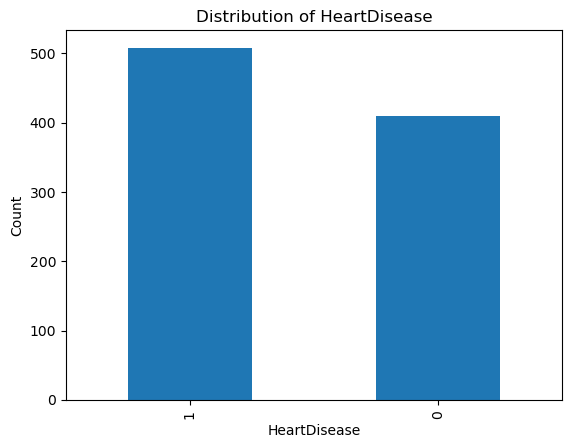

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt  

# Part 1: Processing the data
# Set random seeds to ensure repeatable results
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')

# Check the data type
print("The data type:\n", data.dtypes)

# Check the data size and the number of features
num_features = data.shape[1]  
num_data = data.shape[0]     
print(f"The dataset has {num_data} samples and {num_features} features.")

# Remove missing value
data = data.dropna()

# Convert data into readable form using unique thermal coding
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# Check the processed data and processed data type
print("\nThe head of data：")
print(data.head())
print("\nTotal data (number of rows): ", data.shape[0])
print("Number of features (number of columns): ", data.shape[1])
print("\nThe processed data type: \n", data.dtypes)

# Extract features and labels
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Data standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("\n Normalized data: ")
print(X[:5])

# Data set segmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convert to PyTorch's tensor format
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 检查目标变量的分布
target_counts = data['HeartDisease'].value_counts()

# 打印结果
print("HeartDisease分布：\n", target_counts)

# 可视化
target_counts.plot(kind='bar')
plt.title("Distribution of HeartDisease")
plt.xlabel("HeartDisease")
plt.ylabel("Count")
plt.show()


In [5]:
# Part 2: Design neural network structure
# Define a neural network
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # Build network layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))  # Fully connected layer
        self.layers.append(nn.ReLU())  # Activation function
        self.layers.append(nn.Dropout(p=dropout_rate))  # Dropout is a regularization technique

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))

        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # Output layer
        self.softmax = nn.Softmax(dim=1)  # Output activation function

    # Forward Pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Define hyperparameters
input_size = X_train.shape[1]  # Input size
hidden_layers = [64, 32]  # Number of hidden layers and neurons
dropout_rate = 0.2  # The rate of Dropout
learning_rate = 0.001  # Learning rate
alpha = 0.001  # L2 regularization
num_epochs = 150  # Reduced for multiple experiments
early_stop_patience = 10  # Tolerance number of early stops

# Part 3: Experiment with different training set sizes
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]  # Different proportions of training data
train_accuracies_per_size = []  # Store training accuracies for each training set size
val_accuracies_per_size = []  # Store validation accuracies for each training set size

for train_size in train_sizes:
    # Sample a subset of training data based on the current ratio
    subset_size = int(train_size * len(X_train))
    subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
    
    X_train_subset = X_train[subset_indices]
    y_train_subset = y_train[subset_indices]

    # Convert to PyTorch's tensor format and create DataLoader
    X_train_tensor = torch.tensor(X_train_subset, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_subset, dtype=torch.long)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    # Model Instantiation
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    Loss_fun = nn.CrossEntropyLoss()  # Define Loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)  # Define Optimizer

    # Record training and validation losses and accuracy as well as early stop implementations
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience_counter = 0
    delta = 1e-4  # Tolerate minimal change

    # The training process for each round
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        # Batch-by-batch training
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            # Compute the loss
            loss = Loss_fun(outputs, y_batch)
            # Backward Pass
            loss.backward()
            optimizer.step()

            # Count correct predictions
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        # Calculate average training accuracy
        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Verification phase
        model.eval()
        val_correct = 0

        # Disable gradient calculation
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        # Calculate average validation accuracy
        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stop logic
        val_loss = loss.item()
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    # Record final accuracies for each training set size
    train_accuracies_per_size.append(train_accuracies[-1])
    val_accuracies_per_size.append(val_accuracies[-1])

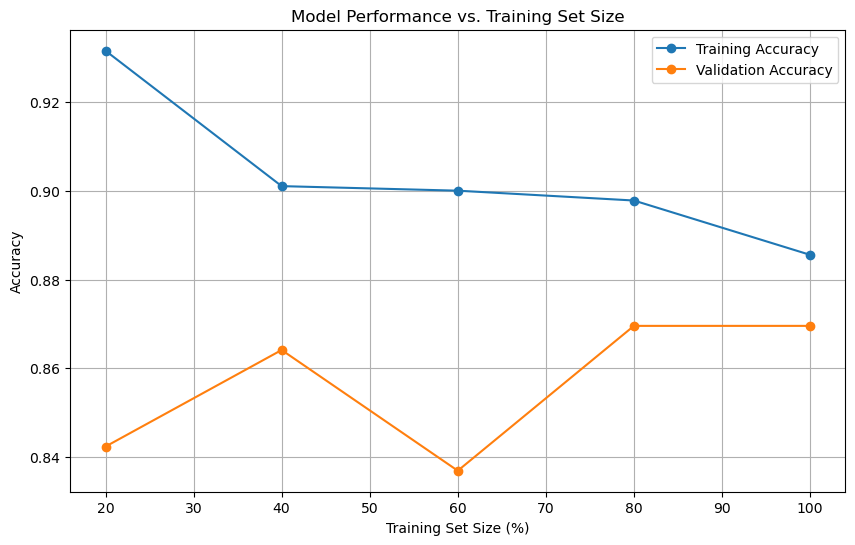

In [6]:

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([int(size * 100) for size in train_sizes], train_accuracies_per_size, label='Training Accuracy', marker='o')
plt.plot([int(size * 100) for size in train_sizes], val_accuracies_per_size, label='Validation Accuracy', marker='o')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.title('Model Performance vs. Training Set Size')
plt.legend()
plt.grid(True)
plt.show()


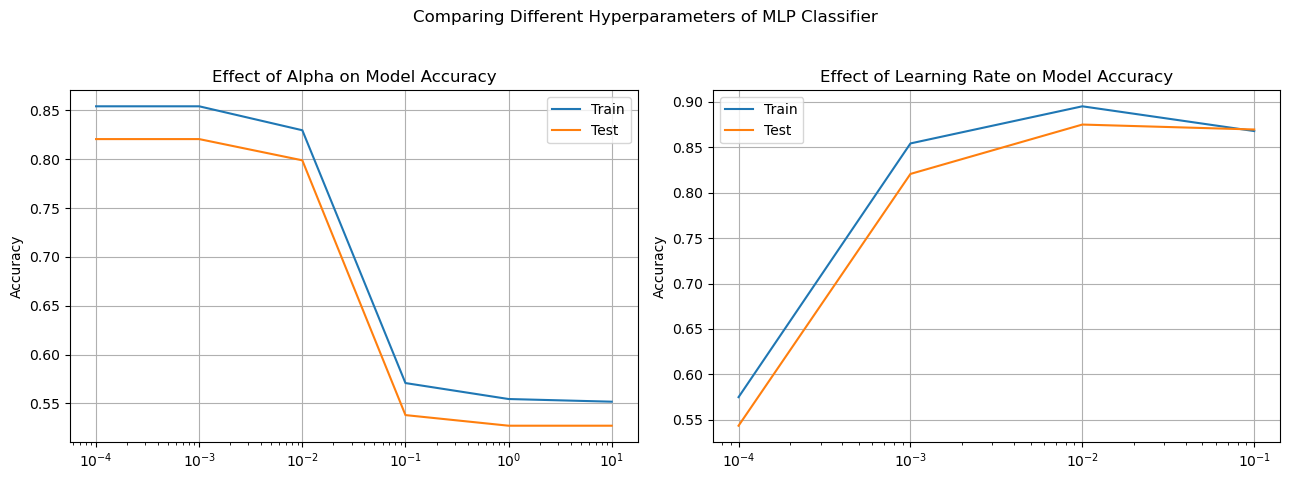

In [111]:
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
seed = 8
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

def train_and_evaluate_model(learning_rate, alpha, hidden_layers, num_epochs=150):
    # Set random seed again to ensure model initialization is consistent across different hyperparameter tests
    set_seed(seed)

    # Instantiate model
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    
    # Tracking metrics
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Validation phase
        model.eval()
        val_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stopping
        if avg_val_acc > best_val_loss + delta:
            best_val_loss = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    return train_accuracies, val_accuracies

# Hyperparameter ranges to explore
learning_rates = [0.1, 0.01, 0.001, 0.0001]
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle('Comparing Different Hyperparameters of MLP Classifier')

# Different Alphas
train_accuracies_alpha = []
test_accuracies_alpha = []
learning_rate = 0.001  # Fix learning rate
hidden_layers = [64, 32]  # Fix hidden layers
for alpha in alphas:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=learning_rate, alpha=alpha, hidden_layers=hidden_layers)
    max_val_acc = max(val_accuracies)
    train_accuracies_alpha.append(train_accuracies[val_accuracies.index(max_val_acc)])
    test_accuracies_alpha.append(max_val_acc)



axes[0].plot(alphas, train_accuracies_alpha, label='Train')
axes[0].plot(alphas, test_accuracies_alpha, label='Test')
axes[0].set_title('Effect of Alpha on Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid()

# Different Learning Rates
train_accuracies_rates = []
test_accuracies_rates = []
alpha = 0.001  # Fix alpha
hidden_layers = [64, 32]  # Fix hidden layers
for rate in learning_rates:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=rate, alpha=alpha, hidden_layers=hidden_layers)
    max_val_acc = max(val_accuracies)
    train_accuracies_rates.append(train_accuracies[val_accuracies.index(max_val_acc)])
    test_accuracies_rates.append(max_val_acc)


axes[1].plot(learning_rates, train_accuracies_rates, label='Train')
axes[1].plot(learning_rates, test_accuracies_rates, label='Test')
axes[1].set_title('Effect of Learning Rate on Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Best alpha: 0.0001 with validation accuracy: 0.8207
Best learning rate: 0.01 with validation accuracy: 0.8750


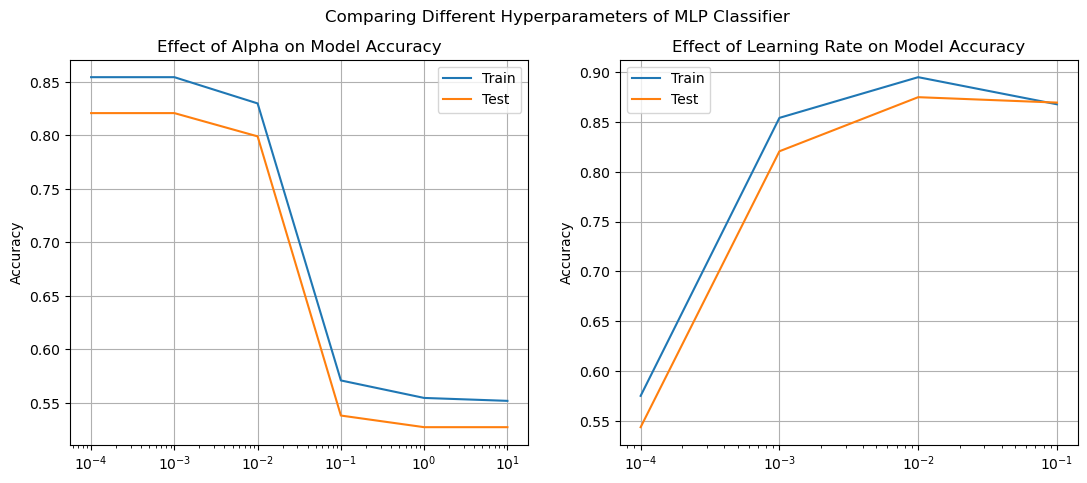

In [112]:
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
seed = 8
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

def train_and_evaluate_model(learning_rate, alpha, hidden_layers, num_epochs=150):
    # Set random seed again to ensure model initialization is consistent across different hyperparameter tests
    set_seed(seed)

    # Instantiate model
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    
    # Tracking metrics
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Validation phase
        model.eval()
        val_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stopping
        if avg_val_acc > best_val_loss + delta:
            best_val_loss = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    return train_accuracies, val_accuracies

# Hyperparameter ranges to explore
learning_rates = [0.1, 0.01, 0.001, 0.0001]
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle('Comparing Different Hyperparameters of MLP Classifier')

# Different Alphas
train_accuracies_alpha = []
test_accuracies_alpha = []
learning_rate = 0.001  # Fix learning rate
hidden_layers = [64, 32]  # Fix hidden layers
best_alpha = None
best_alpha_val_accuracy = 0

for alpha in alphas:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=learning_rate, alpha=alpha, hidden_layers=hidden_layers)
    max_val_acc = max(val_accuracies)
    train_accuracies_alpha.append(train_accuracies[val_accuracies.index(max_val_acc)])
    test_accuracies_alpha.append(max_val_acc)
    
    if max_val_acc > best_alpha_val_accuracy:
        best_alpha_val_accuracy = max_val_acc
        best_alpha = alpha

print(f"Best alpha: {best_alpha} with validation accuracy: {best_alpha_val_accuracy:.4f}")

axes[0].plot(alphas, train_accuracies_alpha, label='Train')
axes[0].plot(alphas, test_accuracies_alpha, label='Test')
axes[0].set_title('Effect of Alpha on Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xscale('log')
axes[0].legend()
axes[0].grid()

# Different Learning Rates
train_accuracies_rates = []
test_accuracies_rates = []
alpha = 0.001  # Fix alpha
hidden_layers = [64, 32]  # Fix hidden layers
best_learning_rate = None
best_lr_val_accuracy = 0

for rate in learning_rates:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=rate, alpha=alpha, hidden_layers=hidden_layers)
    max_val_acc = max(val_accuracies)
    train_accuracies_rates.append(train_accuracies[val_accuracies.index(max_val_acc)])
    test_accuracies_rates.append(max_val_acc)
    
    if max_val_acc > best_lr_val_accuracy:
        best_lr_val_accuracy = max_val_acc
        best_learning_rate = rate

print(f"Best learning rate: {best_learning_rate} with validation accuracy: {best_lr_val_accuracy:.4f}")

axes[1].plot(learning_rates, train_accuracies_rates, label='Train')
axes[1].plot(learning_rates, test_accuracies_rates, label='Test')
axes[1].set_title('Effect of Learning Rate on Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid()

plt.show()


In [114]:
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import numpy as np

def train_and_evaluate_model(learning_rate, alpha, hidden_layers, X_train, y_train, X_val, y_val, num_epochs=150):
    # Set random seed again to ensure model initialization is consistent across different hyperparameter tests
    set_seed(seed)

    # Instantiate model
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    
    # Tracking metrics
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Validation phase
        model.eval()
        val_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stopping
        if avg_val_acc > best_val_loss + delta:
            best_val_loss = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    return train_accuracies, val_accuracies

# Task 1: Report performance of best learning rate on test data
best_learning_rate = 0.01  # From previous experiments
alpha = 0.001  # Fix alpha
hidden_layers = [64, 32]  # Fix hidden layers
train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=best_learning_rate, alpha=alpha, hidden_layers=hidden_layers, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test)

# Evaluate on the test set
model.eval()
test_correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == y_batch).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test accuracy for learning rate {best_learning_rate}: {test_accuracy:.4f}")

# Task 2: Cross-validation for better understanding
kf = KFold(n_splits=10, shuffle=True, random_state=seed)
X_train_array = np.array(X_train)  # Convert X_train to a NumPy array if not already
y_train_array = np.array(y_train)  # Convert y_train to a NumPy array if not already

cross_val_accuracies = []
for train_index, val_index in kf.split(X_train_array):
    X_train_cv, X_val_cv = X_train_array[train_index], X_train_array[val_index]
    y_train_cv, y_val_cv = y_train_array[train_index], y_train_array[val_index]

    _, val_accuracies = train_and_evaluate_model(learning_rate=best_learning_rate, alpha=alpha, hidden_layers=hidden_layers, X_train=X_train_cv, y_train=y_train_cv, X_val=X_val_cv, y_val=y_val_cv)
    cross_val_accuracies.append(max(val_accuracies))

avg_cross_val_accuracy = np.mean(cross_val_accuracies)
print(f"Average cross-validation accuracy for learning rate {best_learning_rate}: {avg_cross_val_accuracy:.4f}")

# Summary of results
print(f"Test accuracy (single split) for learning rate {best_learning_rate}: {test_accuracy:.4f}")
print(f"Average cross-validation accuracy for learning rate {best_learning_rate}: {avg_cross_val_accuracy:.4f}")


Test accuracy for learning rate 0.01: 0.8696
Average cross-validation accuracy for learning rate 0.01: 0.8750
Test accuracy (single split) for learning rate 0.01: 0.8696
Average cross-validation accuracy for learning rate 0.01: 0.8750


The data type:
 Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

The head of data：
   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0  False   True              False  ...              False             False   
1   True  False             

In [9]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds to ensure repeatable results
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')

# Remove missing value
data = data.dropna()

# One-hot encode categorical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# Extract features and labels
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define neural network
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Hyperparameters
learning_rate = 0.001
hidden_layers = [64, 32]
dropout_rate = 0.2
alpha = 0.001
batch_size = 256
num_epochs = 150
k_folds = 5
early_stop_patience = 50
delta = 1e-4  # Tolerate minimal improvement for early stopping

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
best_val_accuracies = []  # Store the best validation accuracy for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Starting fold {fold + 1}/{k_folds}")
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define model, optimizer, and loss function
    model = HeartDiseaseANN(input_size=X_train_tensor.shape[1], hidden_layers=hidden_layers, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Training with early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_val_acc = 0  # Track the best validation accuracy for this fold

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = Loss_fun(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Update best validation accuracy
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc

        # Early stopping logic
        if avg_val_loss < best_val_loss - delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    best_val_accuracies.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

# Compute average of the best validation accuracies
mean_best_val_acc = np.mean(best_val_accuracies)
print(f"\nCross-Validation Mean Best Accuracy: {mean_best_val_acc:.4f}")


Starting fold 1/5
Fold 1 Best Val Accuracy: 0.8696
Starting fold 2/5
Fold 2 Best Val Accuracy: 0.8913
Starting fold 3/5
Fold 3 Best Val Accuracy: 0.8750
Starting fold 4/5
Fold 4 Best Val Accuracy: 0.8852
Starting fold 5/5
Fold 5 Best Val Accuracy: 0.8634

Cross-Validation Mean Best Accuracy: 0.8769


Best learning rate: 0.01 with validation accuracy: 0.9076


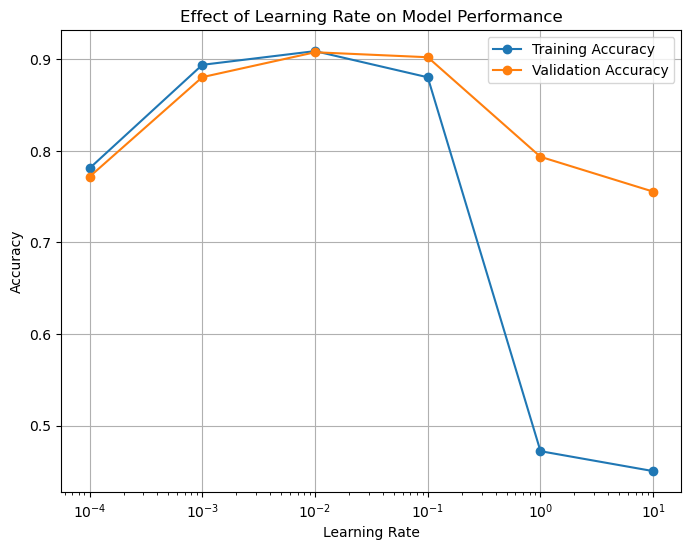

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
seed = 8
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

# Define Neural Network Class
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()

        # Input Layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))

        # Hidden Layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))

        # Output Layer
        self.layers.append(nn.Linear(hidden_layers[-1], 2))  # Binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Function to Train and Evaluate the Model
def train_and_evaluate_model(learning_rate, hidden_layers, num_epochs=150):
    set_seed(seed)  # Ensure consistent results for every hyperparameter setting
    
    # Instantiate model, optimizer, and loss function
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Track accuracies
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    delta = 1e-4  # Early stopping threshold
    
    for epoch in range(num_epochs):
        model.train()
        train_correct = 0

        # Training phase
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()

        avg_train_acc = train_correct / len(train_loader.dataset)
        train_accuracies.append(avg_train_acc)

        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_acc = val_correct / len(test_loader.dataset)
        val_accuracies.append(avg_val_acc)

        # Early stopping check
        if avg_val_acc > best_val_loss + delta:
            best_val_loss = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    return train_accuracies, val_accuracies

# Hyperparameter (Learning Rate) to Explore
learning_rates = [10,1,0.1, 0.01, 0.001, 0.0001]
train_accuracies_rates = []
val_accuracies_rates = []

hidden_layers = [64, 32]  # Fixed architecture
best_learning_rate = None
best_val_accuracy = 0

# Train and Evaluate for Each Learning Rate
for lr in learning_rates:
    train_accuracies, val_accuracies = train_and_evaluate_model(learning_rate=lr, hidden_layers=hidden_layers)
    max_val_acc = max(val_accuracies)
    train_accuracies_rates.append(train_accuracies[val_accuracies.index(max_val_acc)])
    val_accuracies_rates.append(max_val_acc)
    
    if max_val_acc > best_val_accuracy:
        best_val_accuracy = max_val_acc
        best_learning_rate = lr

print(f"Best learning rate: {best_learning_rate} with validation accuracy: {best_val_accuracy:.4f}")

# Plot Results for Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, train_accuracies_rates, label='Training Accuracy', marker='o')
plt.plot(learning_rates, val_accuracies_rates, label='Validation Accuracy', marker='o')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Effect of Learning Rate on Model Performance")
plt.xscale('log')  # Log scale for better visualization
plt.legend()
plt.grid()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')
data = data.dropna()

# One-hot encode categorical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# Extract features and labels
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train, validation, and test sets (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Datasets and DataLoaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Train and evaluate function
def train_and_evaluate(lr, train_loader, val_loader, input_size, hidden_layers, dropout_rate, alpha, num_epochs, patience, delta=1e-4):
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Early stopping
        if avg_val_acc > best_val_acc + delta:
            best_val_acc = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_acc

# Grid search for learning rates
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1]
hidden_layers = [64, 32]
dropout_rate = 0.2
alpha = 0.001
num_epochs = 150
patience=15

# 1. Single split
best_lr_single = None
best_val_acc_single = 0
for lr in learning_rates:
    val_acc = train_and_evaluate(lr, train_loader, val_loader, X_train_tensor.shape[1], hidden_layers, dropout_rate, alpha, num_epochs,patience)
    if val_acc > best_val_acc_single:
        best_val_acc_single = val_acc
        best_lr_single = lr

print(f"Single Split - Best learning rate: {best_lr_single}, Validation Accuracy: {best_val_acc_single:.4f}")

# 2. Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
best_lr_cv = None
best_val_acc_cv = 0

for lr in learning_rates:
    val_accuracies = []
    for train_index, val_index in kf.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        train_dataset_fold = TensorDataset(torch.tensor(X_train_fold, dtype=torch.float32), torch.tensor(y_train_fold, dtype=torch.long))
        val_dataset_fold = TensorDataset(torch.tensor(X_val_fold, dtype=torch.float32), torch.tensor(y_val_fold, dtype=torch.long))

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        val_acc = train_and_evaluate(lr, train_loader_fold, val_loader_fold, X_train_tensor.shape[1], hidden_layers, dropout_rate, alpha, num_epochs,patience)
        val_accuracies.append(val_acc)

    mean_val_acc = np.mean(val_accuracies)
    if mean_val_acc > best_val_acc_cv:
        best_val_acc_cv = mean_val_acc
        best_lr_cv = lr

print(f"Cross-validation - Best learning rate: {best_lr_cv}, Validation Accuracy: {best_val_acc_cv:.4f}")

# Test final performance
def test_model(lr, train_val_loader, test_loader, input_size, hidden_layers, dropout_rate, alpha, num_epochs):
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Train on full train+val data
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_val_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Test
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == y_batch).sum().item()

    test_accuracy = test_correct / len(test_loader.dataset)
    return test_accuracy

train_val_dataset = TensorDataset(torch.tensor(X_train_val, dtype=torch.float32), torch.tensor(y_train_val, dtype=torch.long))
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

test_acc_single = test_model(best_lr_single, train_val_loader, test_loader, X_train_tensor.shape[1], hidden_layers, dropout_rate, alpha, num_epochs)
test_acc_cv = test_model(best_lr_cv, train_val_loader, test_loader, X_train_tensor.shape[1], hidden_layers, dropout_rate, alpha, num_epochs)

print(f"Single Split - Test Accuracy: {test_acc_single:.4f}")
print(f"Cross-validation - Test Accuracy: {test_acc_cv:.4f}")


Single Split - Best learning rate: 0.03, Validation Accuracy: 0.8859
Cross-validation - Best learning rate: 0.003, Validation Accuracy: 0.8856
Single Split - Test Accuracy: 0.8478
Cross-validation - Test Accuracy: 0.8587


In [5]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Set random seed
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')
data = data.dropna()


categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)


X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Scalering
scaler = StandardScaler()
X = scaler.fit_transform(X)

# The dataset is divided into training, validation and test sets (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed)

# Convert to PyTorch's tensor format 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dedine ANN
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Training and Evaluating
def train_and_evaluate(learning_rate):
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience_counter = 0
    
    # The training process
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Verification phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Early Stopping
        if avg_val_acc > best_val_acc + delta:
            best_val_acc = avg_val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_acc

# Define hyperparameters
input_size = X_train_tensor.shape[1] # Input size
hidden_layers = [64,32]  # Number of hidden layers and neurons
dropout_rate = 0.2  # The rate of Dropout
alpha = 0.001  # L2 regularization
num_epochs = 150  # Maximum iterations
patience = 15  # Tolerance number of early stops

# Random learning rate generation (logarithmic random distribution from 0.001 to 0.1)
np.random.seed(seed) 
learning_rates = np.power(10, np.random.uniform(-3, -1, size=50)) # Generate 50 values of random learning rate
print(f"Randomly selected learning rates: {learning_rates}")

# Single validation
best_lr_single = None
best_val_acc_single = 0
for lr in learning_rates:
    val_acc = train_and_evaluate(lr)
    if val_acc > best_val_acc_single:
        best_val_acc_single = val_acc
        best_lr_single = lr

print(f"Single Split - Best learning rate: {best_lr_single}, Validation Accuracy: {best_val_acc_single:.4f}")

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
best_lr_cv = None
best_val_acc_cv = 0

for lr in learning_rates:
    val_accuracies = []
    for train_index, val_index in kf.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        train_dataset_fold = TensorDataset(
            torch.tensor(X_train_fold, dtype=torch.float32),
            torch.tensor(y_train_fold, dtype=torch.long),
        )
        val_dataset_fold = TensorDataset(
            torch.tensor(X_val_fold, dtype=torch.float32),
            torch.tensor(y_val_fold, dtype=torch.long),
        )

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

        val_acc = train_and_evaluate(lr)
        val_accuracies.append(val_acc)

    mean_val_acc = np.mean(val_accuracies)
    if mean_val_acc > best_val_acc_cv:
        best_val_acc_cv = mean_val_acc
        best_lr_cv = lr

print(f"Cross-validation - Best learning rate: {best_lr_cv}, Validation Accuracy: {best_val_acc_cv:.4f}")

# Test final performance on the test set
def test_model(lr):
    model = HeartDiseaseANN(input_size, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_val_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == y_batch).sum().item()

    test_accuracy = test_correct / len(test_loader.dataset)
    return test_accuracy

train_val_dataset = TensorDataset(
    torch.tensor(X_train_val, dtype=torch.float32),
    torch.tensor(y_train_val, dtype=torch.long),
)
train_val_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

test_acc_single = test_model(best_lr_single)
test_acc_cv = test_model(best_lr_cv)

print(f"Single Split - Test Accuracy: {test_acc_single:.4f}")
print(f"Cross-validation - Test Accuracy: {test_acc_cv:.4f}")


Randomly selected learning rates: [0.05582887 0.08651299 0.05475062 0.01152687 0.0029205  0.0010539
 0.00726002 0.00637827 0.01110067 0.00905281 0.01290366 0.01221158
 0.03324996 0.02659189 0.01735259 0.00711514 0.00378573 0.08865648
 0.00465102 0.00273906 0.00135399 0.09241471 0.00180182 0.0044082
 0.00138639 0.0028154  0.00612731 0.06198549 0.00490821 0.09321781
 0.00114147 0.00505091 0.00577987 0.03375361 0.07544107 0.00435893
 0.00732743 0.0034697  0.04000477 0.01890069 0.00137208 0.01611718
 0.03900759 0.00115882 0.00814509 0.03804916 0.09488401 0.01472072
 0.00119626 0.0078135 ]
Single Split - Best learning rate: 0.017352585470549044, Validation Accuracy: 0.8967
Cross-validation - Best learning rate: 0.03900758979047539, Validation Accuracy: 0.8859
Single Split - Test Accuracy: 0.8424
Cross-validation - Test Accuracy: 0.8750


In [ ]:
#最普通的交叉验证

import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds to ensure repeatable results
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('heart2.csv')

# Remove missing value
data = data.dropna()

# One-hot encode categorical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)

# Extract features and labels
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define neural network
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Hyperparameters
learning_rate = 0.01
hidden_layers = [64, 32]
dropout_rate = 0.2
alpha = 0.001
batch_size = 256
num_epochs = 150
early_stop_patience = 20
delta = 1e-4  # Tolerate minimal improvement for early stopping


k_folds = 5  # Number of folders
# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
best_val_accuracies = []  # Store the best validation accuracy for each fold

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Starting fold {fold + 1}/{k_folds}")
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define model, optimizer, and loss function
    model = HeartDiseaseANN(input_size=X_train_tensor.shape[1], hidden_layers=hidden_layers, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()

    # Training with early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_val_acc = 0  # Track the best validation accuracy for this fold

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = Loss_fun(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == y_batch).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_correct / len(val_loader.dataset)

        # Update best validation accuracy
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc

        # Early stopping logic
        if avg_val_loss < best_val_loss - delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    best_val_accuracies.append(best_val_acc)
    print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")

# Compute average of the best validation accuracies
mean_best_val_acc = np.mean(best_val_accuracies)
print(f"\nCross-Validation Mean Best Accuracy: {mean_best_val_acc:.4f}")


Training with config: {'label': 'No Regularization', 'dropout_rate': 0, 'alpha': 0}
Training with config: {'label': 'Dropout Only', 'dropout_rate': 0.2, 'alpha': 0}
Training with config: {'label': 'L2 Only', 'dropout_rate': 0, 'alpha': 0.001}
Training with config: {'label': 'Dropout + L2', 'dropout_rate': 0.2, 'alpha': 0.001}


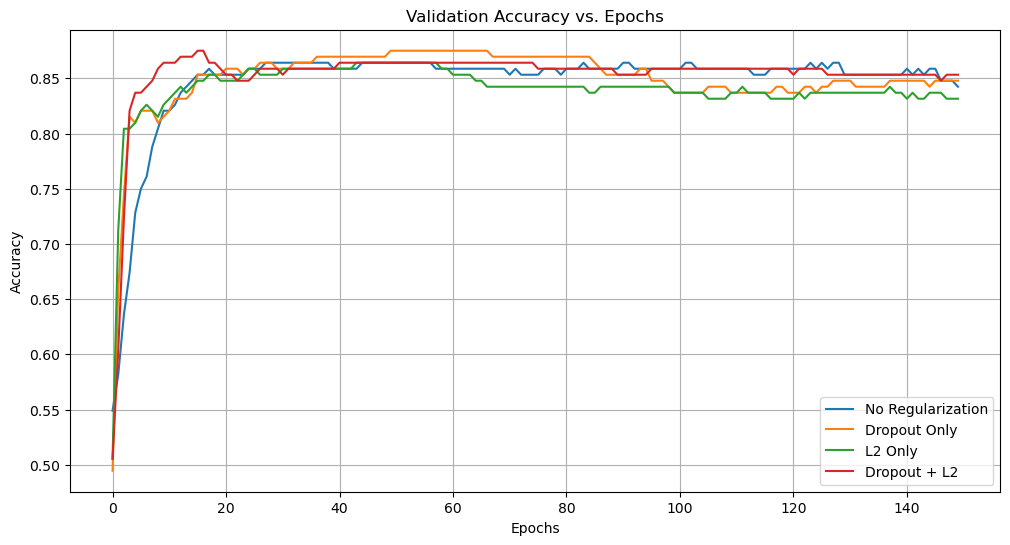

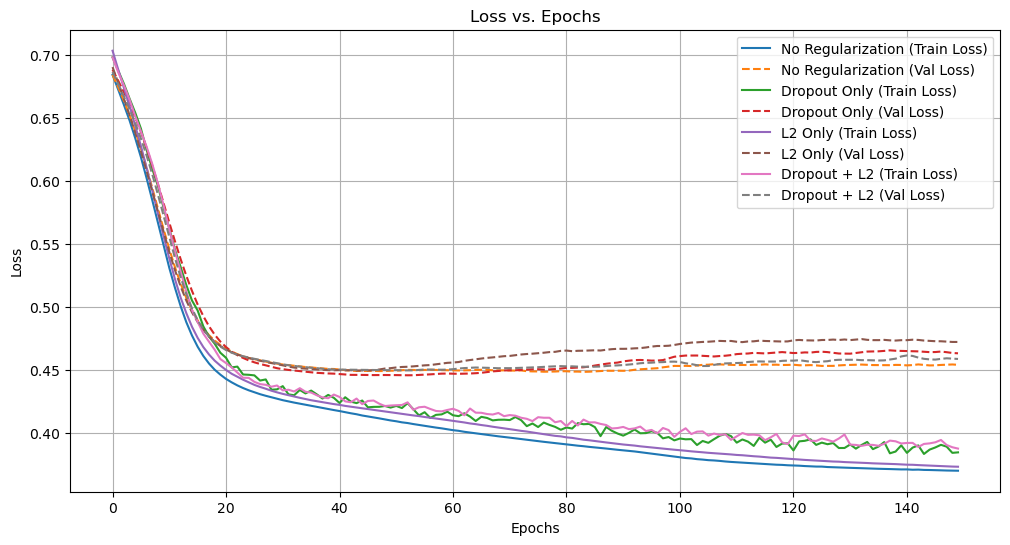

In [5]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load and preprocess data
data = pd.read_csv('heart2.csv').dropna()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
batch_size = 256
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)), 
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.long)), 
                        batch_size=batch_size, shuffle=False)

# Neural Network Class (unchanged)
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Training function
def train_and_evaluate(dropout_rate, alpha, num_epochs):
    model = HeartDiseaseANN(input_size=X_train.shape[1], hidden_layers=[64, 32], dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = Loss_fun(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))
    
    return train_losses, val_losses, val_accuracies

# Experiment configurations
configs = [
    {"label": "No Regularization", "dropout_rate": 0, "alpha": 0},
    {"label": "Dropout Only", "dropout_rate": 0.2, "alpha": 0},
    {"label": "L2 Only", "dropout_rate": 0, "alpha": 0.001},
    {"label": "Dropout + L2", "dropout_rate": 0.2, "alpha": 0.001},
]

# Run experiments and collect results
results = {}
num_epochs = 150
for config in configs:
    print(f"Training with config: {config}")
    train_losses, val_losses, val_accuracies = train_and_evaluate(config["dropout_rate"], config["alpha"], num_epochs)
    results[config["label"]] = {"train_losses": train_losses, "val_losses": val_losses, "val_accuracies": val_accuracies}

# Plot results
plt.figure(figsize=(12, 6))
for label, result in results.items():
    plt.plot(result["val_accuracies"], label=label)
plt.title("Validation Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
for label, result in results.items():
    plt.plot(result["train_losses"], label=f"{label} (Train Loss)")
    plt.plot(result["val_losses"], linestyle="--", label=f"{label} (Val Loss)")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [20]:
from sklearn.model_selection import KFold

# Generate random hyperparameters
dropout_rates = np.random.uniform(0.01, 0.5, 20)
alphas = np.random.uniform(0.00001, 0.001, 30)
parameter_combinations = [(d, a) for d in dropout_rates for a in alphas]

# Perform cross-validation
def cross_validate(dropout_rate, alpha, num_epochs=100, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    val_accuracies = []
    val_losses = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_train_fold = torch.tensor(X_train[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y_train[train_idx], dtype=torch.long)
        X_val_fold = torch.tensor(X_train[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y_train[val_idx], dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size, shuffle=False)

        # Train and evaluate
        train_losses, val_losses_fold, train_accuracies, val_accuracies_fold = train_and_evaluate(
            dropout_rate, alpha, num_epochs)
        
        val_losses.append(np.mean(val_losses_fold))
        val_accuracies.append(np.mean(val_accuracies_fold))
    
    return np.mean(val_losses), np.mean(val_accuracies)

# Evaluate all parameter combinations
results = []
for dropout_rate, alpha in parameter_combinations:
    val_loss, val_accuracy = cross_validate(dropout_rate, alpha)
    results.append((dropout_rate, alpha, val_loss, val_accuracy))

# Find the best parameters
best_params = sorted(results, key=lambda x: x[2])  # Sort by lowest validation loss
best_dropout, best_alpha, best_loss, best_acc = best_params[0]
print(f"Best Dropout: {best_dropout}, Best Alpha: {best_alpha}, "
      f"Validation Loss: {best_loss}, Validation Accuracy: {best_acc}")


Best Dropout: 0.08984657734408957, Best Alpha: 6.387794628700669e-05, Validation Loss: 0.4681232018470764, Validation Accuracy: 0.8563586956521739


Training with config: {'label': 'No Regularization', 'dropout_rate': 0, 'alpha': 0}
Training with config: {'label': 'Dropout Only', 'dropout_rate': 0.2, 'alpha': 0}
Training with config: {'label': 'L2 Only', 'dropout_rate': 0, 'alpha': 0.001}
Training with config: {'label': 'Dropout + L2', 'dropout_rate': 0.2, 'alpha': 0.001}


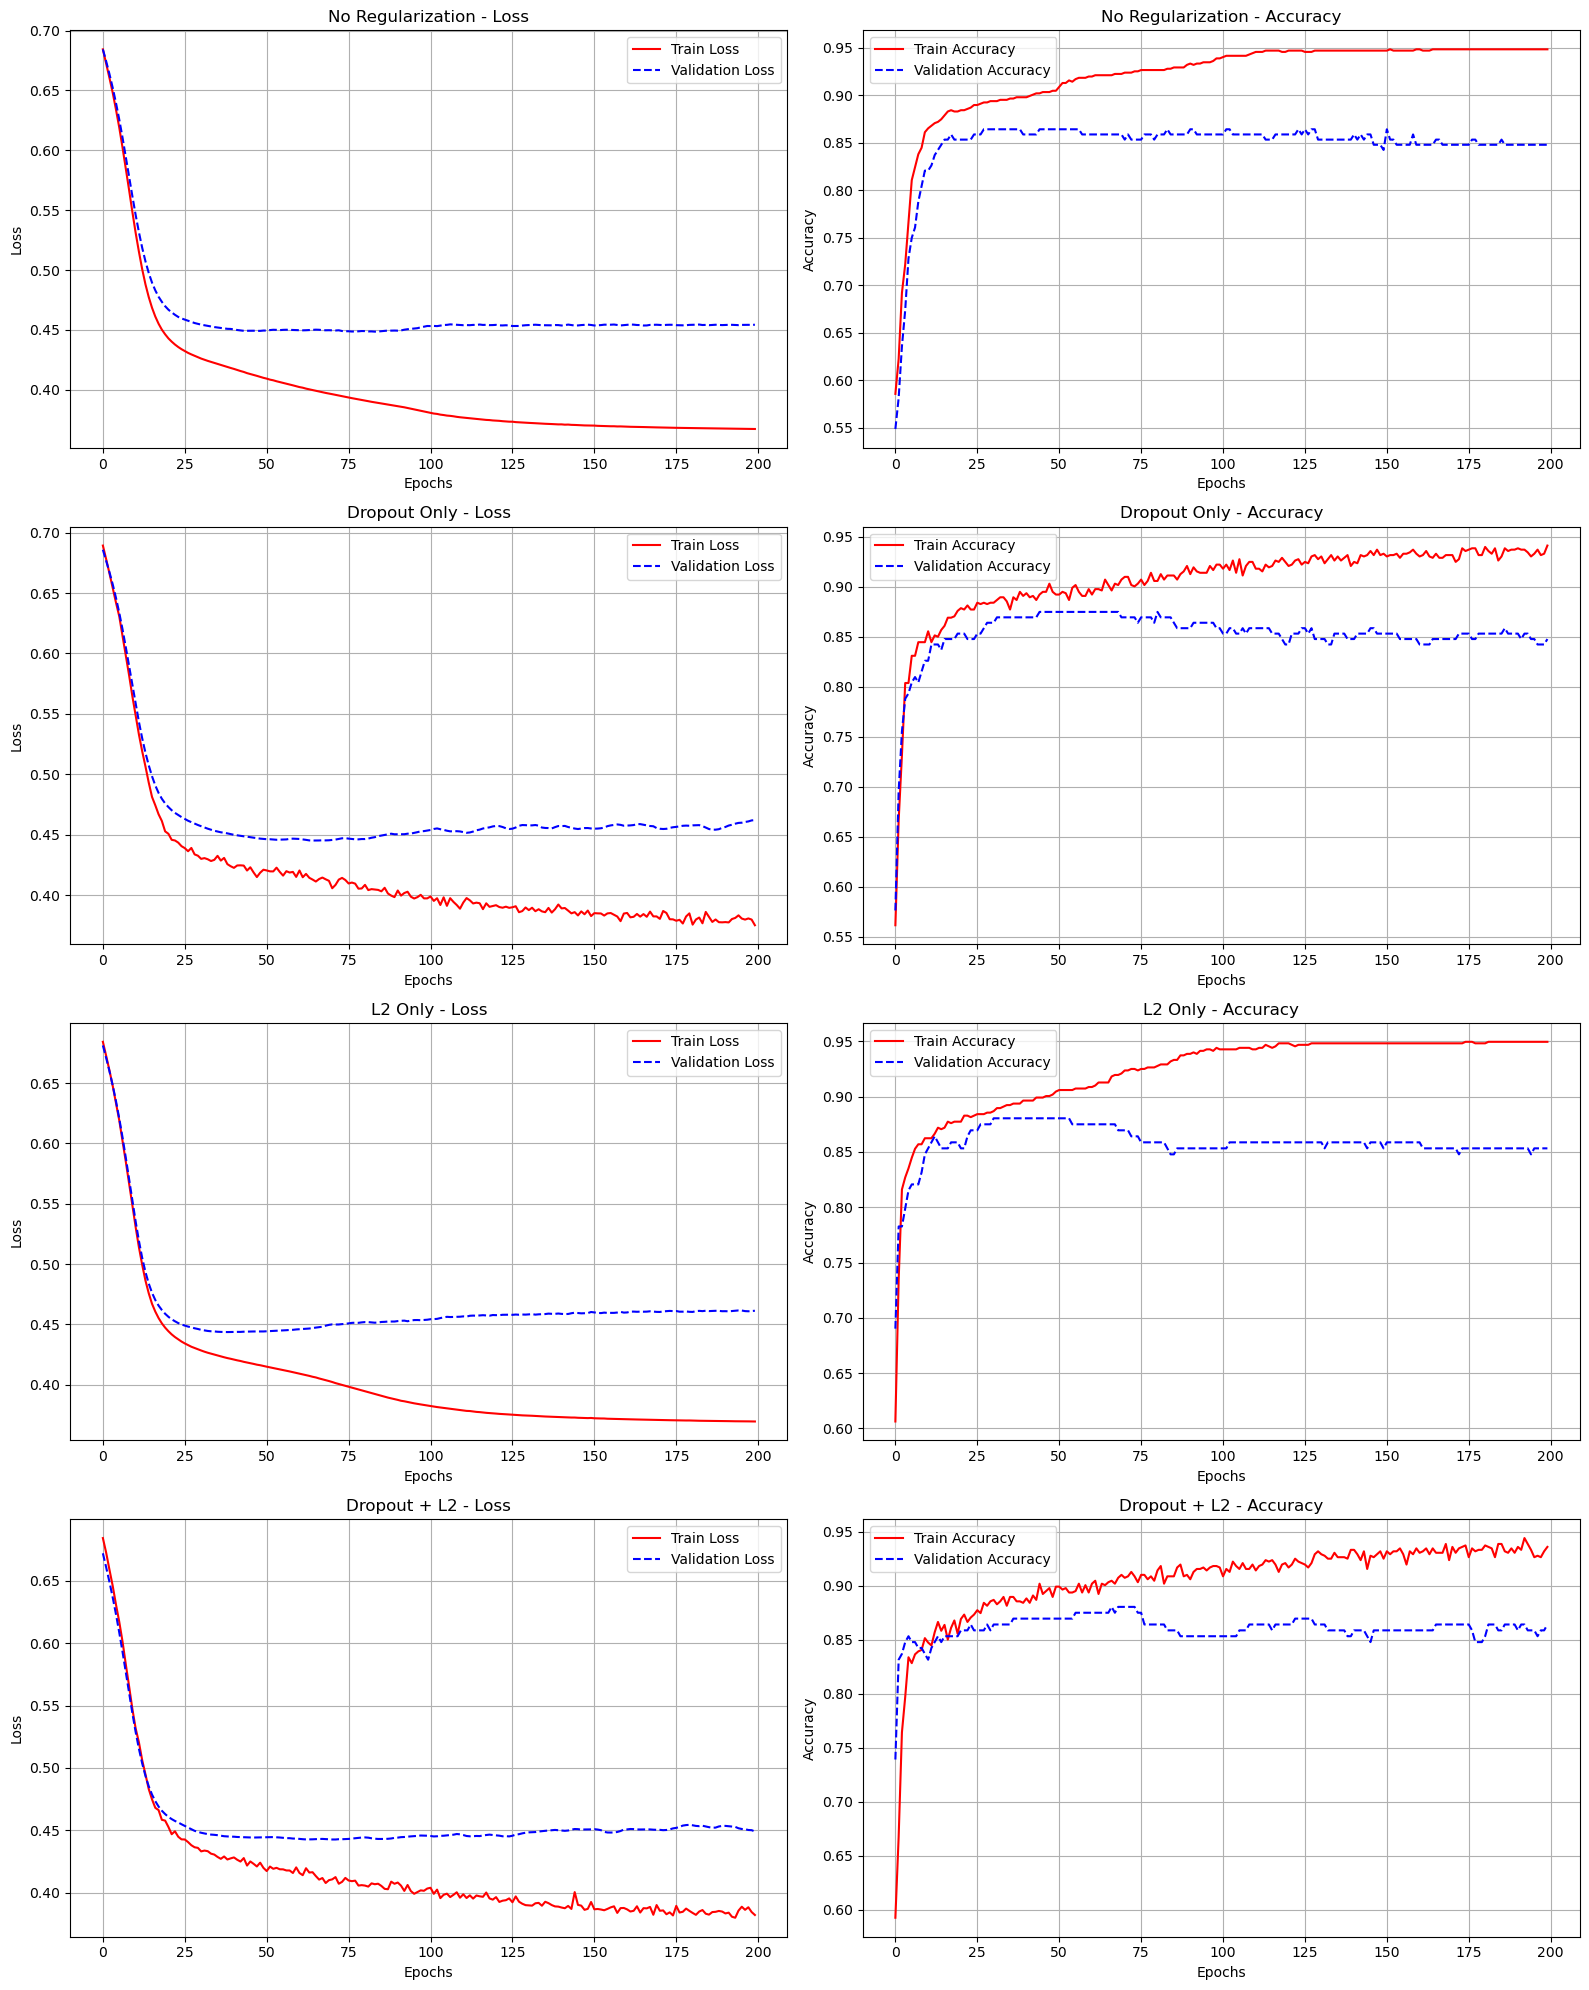

In [12]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load and preprocess data
data = pd.read_csv('heart2.csv').dropna()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data = pd.get_dummies(data, columns=categorical_cols)
X = data.drop(columns=['HeartDisease']).values
y = data['HeartDisease'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Convert to PyTorch tensors
batch_size = 256
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.long)), 
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.long)), 
                        batch_size=batch_size, shuffle=False)

# Neural Network Class (unchanged)
class HeartDiseaseANN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate):
        super(HeartDiseaseANN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_rate))
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(hidden_layers[-1], 2))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

# Training function
def train_and_evaluate(dropout_rate, alpha, num_epochs):
    model = HeartDiseaseANN(input_size=X_train.shape[1], hidden_layers=[64, 32], dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=alpha)
    Loss_fun = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = Loss_fun(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = Loss_fun(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(dim=1) == y_batch).sum().item()
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Experiment configurations
configs = [
    {"label": "No Regularization", "dropout_rate": 0, "alpha": 0},
    {"label": "Dropout Only", "dropout_rate": 0.2, "alpha": 0},
    {"label": "L2 Only", "dropout_rate": 0, "alpha": 0.001},
    {"label": "Dropout + L2", "dropout_rate": 0.2, "alpha": 0.001},
]

# Run experiments and collect results
results = {}
num_epochs = 200
for config in configs:
    print(f"Training with config: {config}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(config["dropout_rate"], config["alpha"], num_epochs)
    results[config["label"]] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

# Plot results (2x4 layout)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, (label, result) in enumerate(results.items()):
    # Plot train/val losses
    axes[2*idx].plot(result["train_losses"], label="Train Loss", color='red')
    axes[2*idx].plot(result["val_losses"], label="Validation Loss", linestyle="--", color='blue')
    axes[2*idx].set_title(f"{label} - Loss")
    axes[2*idx].set_xlabel("Epochs")
    axes[2*idx].set_ylabel("Loss")
    axes[2*idx].legend()
    axes[2*idx].grid()

    # Plot train/val accuracies
    axes[2*idx+1].plot(result["train_accuracies"], label="Train Accuracy", color='red')
    axes[2*idx+1].plot(result["val_accuracies"], label="Validation Accuracy", linestyle="--", color='blue')
    axes[2*idx+1].set_title(f"{label} - Accuracy")
    axes[2*idx+1].set_xlabel("Epochs")
    axes[2*idx+1].set_ylabel("Accuracy")
    axes[2*idx+1].legend()
    axes[2*idx+1].grid()

plt.tight_layout()
plt.show()


In [14]:
# Print final results numerically with median of differences
print("\nFinal Results (Median of Differences):")
window = 20  # Use the last 20 epochs for evaluation
for label, result in results.items():
    # Compute the difference between training and validation for the last `window` epochs
    loss_differences = np.abs(np.array(result["train_losses"][-window:]) - np.array(result["val_losses"][-window:]))
    acc_differences = np.abs(np.array(result["train_accuracies"][-window:]) - np.array(result["val_accuracies"][-window:]))
    
    # Calculate the median of the differences
    loss_gap_median = np.median(loss_differences)
    acc_gap_median = np.median(acc_differences)
    
    # Print results
    print(f"{label}: Median Loss Gap={loss_gap_median:.4f}, Median Accuracy Gap={acc_gap_median:.4f}")



Final Results (Median of Differences):
No Regularization: Median Loss Gap=0.0865, Median Accuracy Gap=0.1004
Dropout Only: Median Loss Gap=0.0781, Median Accuracy Gap=0.0841
L2 Only: Median Loss Gap=0.0912, Median Accuracy Gap=0.0963
Dropout + L2: Median Loss Gap=0.0681, Median Accuracy Gap=0.0718
